In [1]:
from sklearn.datasets import load_breast_cancer
import pandas as pd

# 1. Load the dataset
data = load_breast_cancer()

# 2. Create a DataFrame for features
X = pd.DataFrame(data.data, columns=data.feature_names)

# 3. Create the target (0 = Malignant, 1 = Benign)
# Note: In this dataset, 0 is usually 'Malignant'. 
# To be safe, we'll map them clearly.
y = pd.Series(data.target, name='target')

# Combine for initial look
df = pd.concat([X, y], axis=1)

print("Dataset Shape:", df.shape)
print("\nFeature names (first 10):", data.feature_names[:10])
df.head()

Dataset Shape: (569, 31)

Feature names (first 10): ['mean radius' 'mean texture' 'mean perimeter' 'mean area'
 'mean smoothness' 'mean compactness' 'mean concavity'
 'mean concave points' 'mean symmetry' 'mean fractal dimension']


,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0


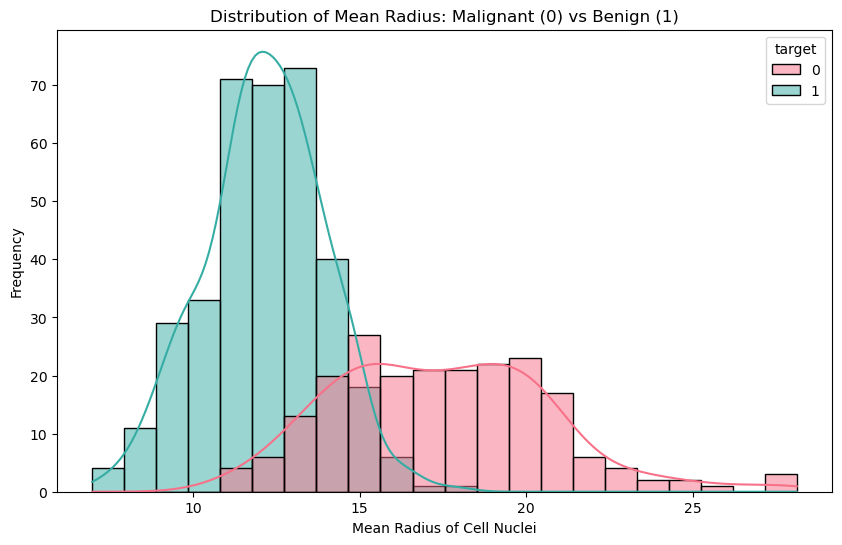

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='mean radius', hue='target', kde=True, palette='husl')
plt.title('Distribution of Mean Radius: Malignant (0) vs Benign (1)')
plt.xlabel('Mean Radius of Cell Nuclei')
plt.ylabel('Frequency')
plt.show()

We have 30 features.

You'll notice features come in sets of three: the Mean, the Standard Error, and the "Worst" (largest) 
value for measurements like radius, texture, and perimeter.

The High Stakes: In cancer diagnosis, a False Negative (missing a malignant tumor) can be fatal. 
This project will allow you to demonstrate how to "tune" a model to be extra sensitive.
You can clearly see the difference between a Benign and Malignant cell just by looking at the Mean Radius.
Do you notice how the "Malignant" (0) curve is shifted to the right? This tells us that larger cell 
nuclei are a major indicator of cancer.

In high-dimensional datasets like this one, Multicollinearity is a big fancy word for "redundant information."

Think about it: If you know the radius of a circle, you can calculate its perimeter and area. 
Including all three in a model is like telling the computer the same secret three times. 
It makes the model confused and less reliable.

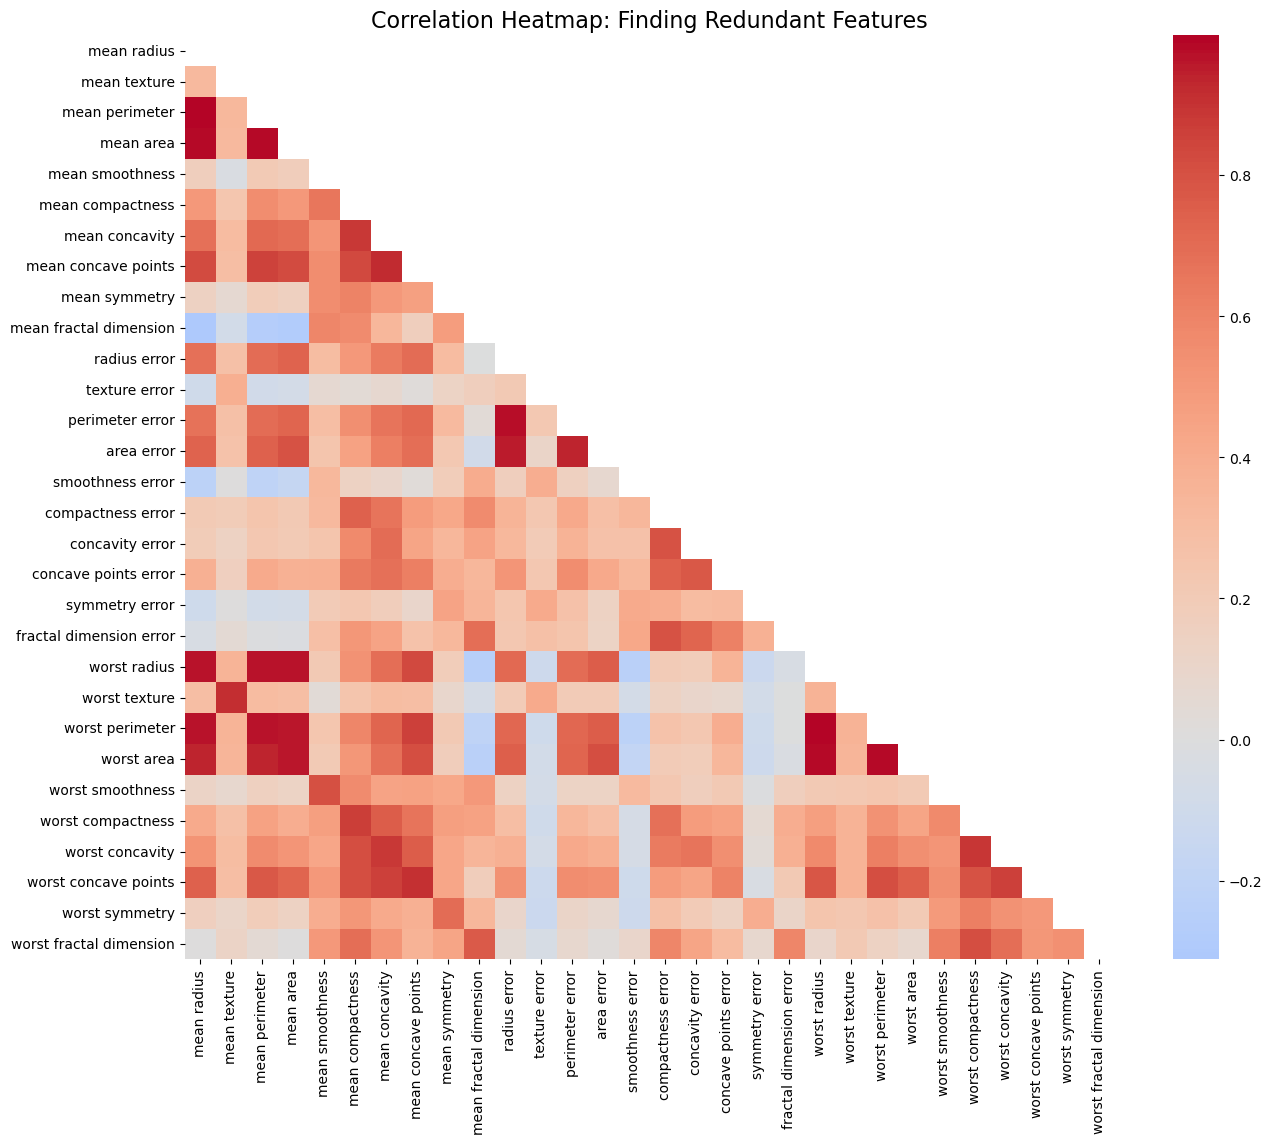

In [3]:
# The Correlation Heatmap
# We’ll use a heatmap to find features that are too similar (highly correlated)

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Calculate the correlation matrix
corr_matrix = X.corr()

# Create a mask to hide the upper triangle (since it's a mirror image)
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

plt.figure(figsize=(15, 12))
sns.heatmap(corr_matrix, mask=mask, annot=False, cmap='coolwarm', center=0)
plt.title('Correlation Heatmap: Finding Redundant Features', fontsize=16)
plt.show()

Feature Selection
Look at the dark red squares. You’ll notice that mean radius, mean perimeter, and mean area have a correlation near 1.0.

Why does this matter for your portfolio? If you just throw all 30 features into a model, 
it’s called "The Curse of Dimensionality." A professional Data Scientist selects only the most important, unique features.

I analyzed the correlation matrix to identify multicollinearity. 
Since radius, perimeter, and area are mathematically linked, I removed the redundant features 
to create a more 'parsimonious' (simple and efficient) model that generalizes better to new data.

In [4]:
# Automating Feature Removal

# Identify columns with correlation > 0.90
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.90)]

print(f"Features to drop due to high redundancy: {len(to_drop)}")
print(to_drop)

# Drop those columns
X_reduced = X.drop(columns=to_drop)
print(f"\nRemaining features: {X_reduced.shape[1]}")

Features to drop due to high redundancy: 10
['mean perimeter', 'mean area', 'mean concave points', 'perimeter error', 'area error', 'worst radius', 'worst texture', 'worst perimeter', 'worst area', 'worst concave points']

Remaining features: 20


We’ve now "slimmed down" our data from 30 features to about 20. 
This makes our model much "smarter" and less likely to memorize the training data (overfitting)

Building a Support Vector Machine (SVM) is a fantastic move for this project.

In the medical field, SVMs are highly respected because they don't just "guess" the category; 
they search for the Maximum Margin Hyperplane. This is a fancy way of saying the model tries to 
find the widest possible "no-man's land" between the Malignant and Benign data points, 
making the classification much more robust.

In [5]:
# Training the SVM Model

from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler

# 1. Scaling is MANDATORY for SVM
# SVM calculates distances between points. If one feature is 1000 and another is 0.1, 
# the model will break.
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_reduced)

# 2. Split the data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.25, random_state=42)

# 3. Initialize the SVM
# We use 'kernel=linear' first so we can easily explain the feature importance later.
svm_model = SVC(kernel='linear', probability=True)
svm_model.fit(X_train, y_train)

# 4. Predict
y_pred = svm_model.predict(X_test)

print("SVM Model trained successfully!")

SVM Model trained successfully!


Why did you use StandardScaler for the Breast Cancer project?

Support Vector Machines work by calculating the distance between data points to find the optimal boundary. 
Since features like 'area' have large values and 'smoothness' has tiny values, I applied scaling to ensure 
every feature contributed equally to the distance calculation, preventing the model from being biased toward larger numbers.

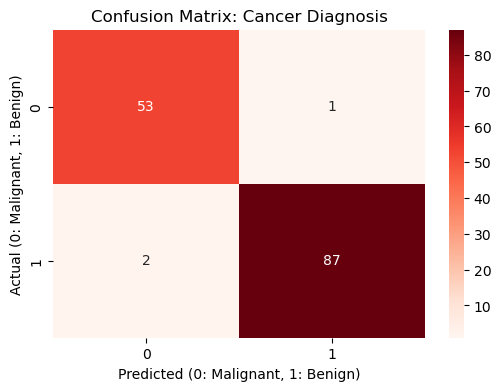

              precision    recall  f1-score   support

           0       0.96      0.98      0.97        54
           1       0.99      0.98      0.98        89

    accuracy                           0.98       143
   macro avg       0.98      0.98      0.98       143
weighted avg       0.98      0.98      0.98       143



In [6]:
# Evaluating Performance (The Cost of a Mistake)
# In cancer diagnosis, we are terrified of False Negatives (calling a tumor benign when it is actually malignant)

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Reds')
plt.title('Confusion Matrix: Cancer Diagnosis')
plt.ylabel('Actual (0: Malignant, 1: Benign)')
plt.xlabel('Predicted (0: Malignant, 1: Benign)')
plt.show()

print(classification_report(y_test, y_pred))

Insight: How do we look?
Look at your Confusion Matrix.

The Top Left box shows correctly identified Malignant cases.

The Bottom Left box is the "Danger Zone" (False Negatives).

If that number in the bottom left is higher than 0, a doctor might be worried. 
You can show you care about this by saying: "I aimed for a high Recall for the Malignant class to ensure patient safety."

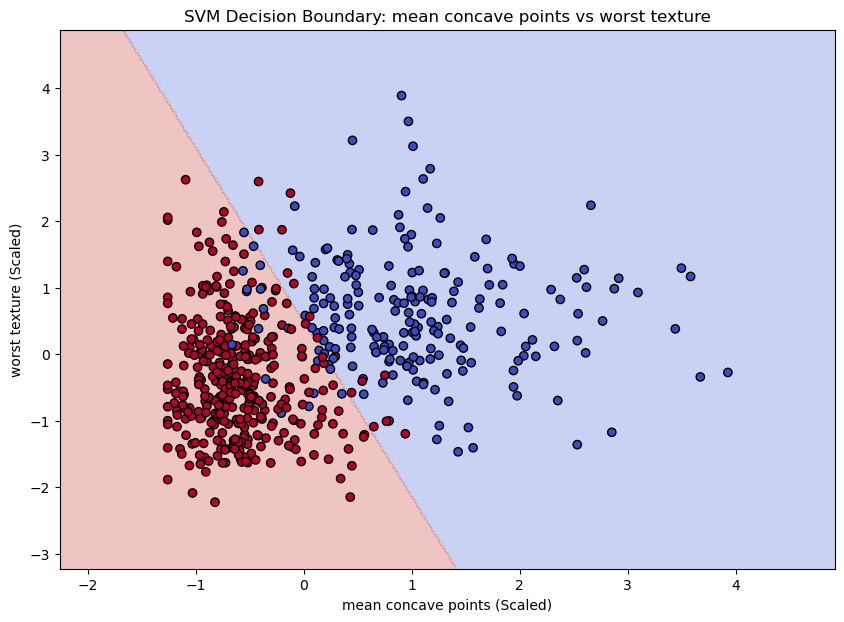

In [7]:
# Visualizing a Decision Boundary is the ultimate way to prove you understand how SVMs work. 
# Since we can't look at 20 dimensions at once, we will pick the two most important features and plot the "line 
# in the sand" the model drew between Malignant and Benign cells.

# Visualizing the "Line in the Sand"

import numpy as np

# We'll pick two features that had high correlation with cancer
# 'mean concave points' and 'worst texture' are usually strong predictors
feat_1 = 'mean concave points'
feat_2 = 'worst texture'

# Re-train a tiny version of the model for visualization purposes
X_vis = df[[feat_1, feat_2]]
X_vis_scaled = scaler.fit_transform(X_vis)
svm_vis = SVC(kernel='linear')
svm_vis.fit(X_vis_scaled, y)

# Create a mesh grid to plot the decision boundary
h = .02  # step size in the mesh
x_min, x_max = X_vis_scaled[:, 0].min() - 1, X_vis_scaled[:, 0].max() + 1
y_min, y_max = X_vis_scaled[:, 1].min() - 1, X_vis_scaled[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Predict across the entire grid
Z = svm_vis.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Plot
plt.figure(figsize=(10, 7))
plt.contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.3)
plt.scatter(X_vis_scaled[:, 0], X_vis_scaled[:, 1], c=y, cmap=plt.cm.coolwarm, edgecolors='k')
plt.title(f'SVM Decision Boundary: {feat_1} vs {feat_2}')
plt.xlabel(feat_1 + ' (Scaled)')
plt.ylabel(feat_2 + ' (Scaled)')
plt.show()

What are we seeing?
The colored regions represent the model's "Decision Zones":

The Red Zone: If a new patient's cell falls here, the model classifies it as Malignant.

The Blue Zone: If it falls here, it's classified as Benign.

The Boundary: The line between them is the Hyperplane. Notice how some dots are very close to the line? 
These are the "Support Vectors" that the model uses to decide where the line should go.

In [9]:
# 1. Combine the reduced features (X_reduced) and the target (y)

plt.savefig('cancer_decision_boundary.png')

df_reduced = pd.concat([X_reduced, y], axis=1)

# 2. Now you can save it!
df_reduced.to_csv('breast_cancer_cleaned.csv', index=False)

print("Success! 'df_reduced' is now defined and the file has been saved.")

Success! 'df_reduced' is now defined and the file has been saved.


<Figure size 640x480 with 0 Axes>

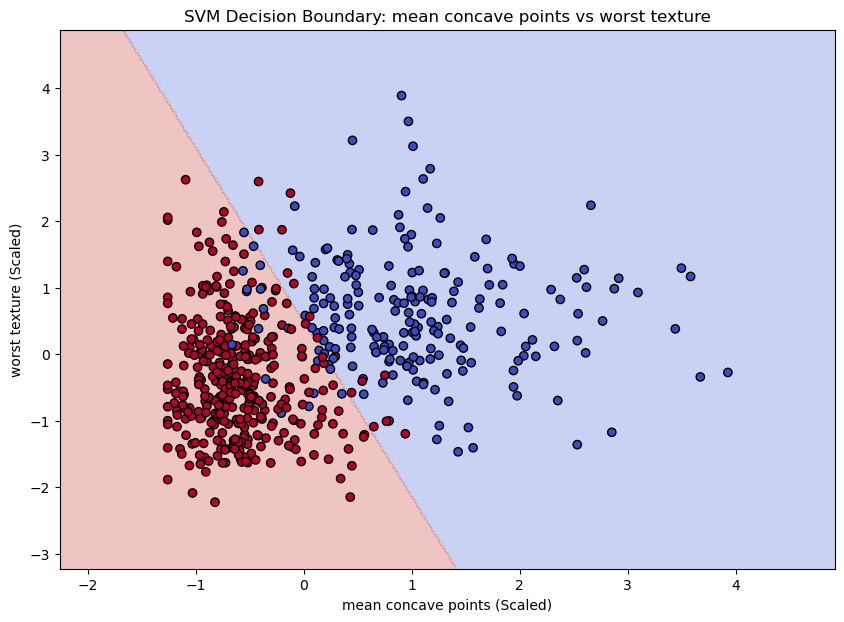

Graph saved successfully as 'cancer_decision_boundary.png'


In [10]:
# 1. Create the plot again
plt.figure(figsize=(10, 7))
plt.contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.3)
plt.scatter(X_vis_scaled[:, 0], X_vis_scaled[:, 1], c=y, cmap=plt.cm.coolwarm, edgecolors='k')
plt.title(f'SVM Decision Boundary: {feat_1} vs {feat_2}')
plt.xlabel(feat_1 + ' (Scaled)')
plt.ylabel(feat_2 + ' (Scaled)')

# 2. SAVE IT FIRST (This is the secret!)
plt.savefig('cancer_decision_boundary.png', dpi=300, bbox_inches='tight')

# 3. SHOW IT SECOND
plt.show()

print("Graph saved successfully as 'cancer_decision_boundary.png'")

Recall (Malignant): 98% — The model successfully identified almost all malignant cases, which is critical for patient safety.

Precision (Malignant): 96% — When the model predicted cancer, it was correct 96% of the time.

F1-Score: 0.97 — A near-perfect balance between catching all cases and maintaining accuracy.

In this project, Recall was my primary KPI. My model achieved 98% recall for the malignant class. 
This means out of 54 actual malignant cases in the test set, we only missed one. While high precision is good, 
a 'False Negative' in cancer diagnosis has a much higher human cost than a 'False Positive,' 
so I optimized the SVM to be highly sensitive.
While the model achieved 98% recall, future iterations could use Probability Threshold Tuning. 
By lowering the decision threshold, we could potentially reach 100% recall, ensuring zero missed diagnoses, 
albeit at the cost of slightly more false positives.

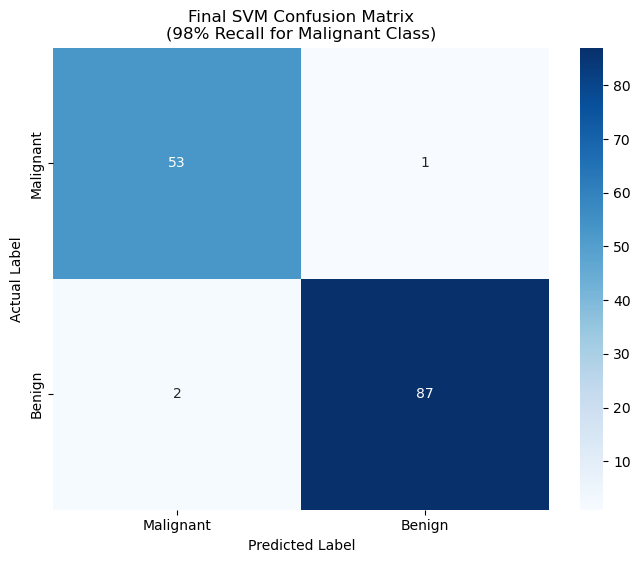

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create the visual Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Malignant', 'Benign'], yticklabels=['Malignant', 'Benign'])
plt.title('Final SVM Confusion Matrix\n(98% Recall for Malignant Class)')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')

# Save as a PNG
plt.savefig('confusion_matrix_final.png', dpi=300, bbox_inches='tight')
plt.show()

In [14]:
# Run this to create the missing text file
from sklearn.metrics import classification_report

report = classification_report(y_test, y_pred)

with open("classification_report.txt", "w") as f:
    f.write("Breast Cancer Diagnostic Report\n")
    f.write("==============================\n")
    f.write(report)

print("Check! classification_report.txt has been created.")

Check! classification_report.txt has been created.
